# TruthFinder: A Machine Learning Approach to Fake News Detection

 The purpose of this notebook is to classify fake news from real news using a Long Short-Term Memory (LSTM) Recurrent Neural Network (RNN).

**Dataset Used**:
* "FakeNewsNet" by Aleksei Golovin (__[Kaggle Link](https://www.kaggle.com/datasets/algord/fake-news/data)__)

## STEP 1: Importing Necessary Libraries & Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
plt.style.use('ggplot')

## STEP 2: Loading and Preprocessing the Data

### Reading the CSV file and Converting to a DataFrame

In [ ]:
news_df = pd.read_csv('/content/FakeNewsNet.csv')

print('Total number of news articles:', len(news_df))
news_df

Total number of news articles: 23196


,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
...,...,...,...,...,...
23191,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1
23192,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0
23193,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1
23194,"Tristan Thompson Feels ""Dumped"" After Khloé Ka...",www.intouchweekly.com/posts/tristan-thompson-f...,www.intouchweekly.com,24,0


### Cleaning and Reformatting the DataFrame

* 0 = real news artilces
* 1 = fake news article

In [ ]:
#renaming the "real" column to "label"
news_df.rename(columns = {'real': 'label'}, inplace = True)

#dropna() is used to remove missing values
news_df.dropna(inplace=True)

news_df.reset_index(inplace=True)

#The irrelevant columns are dropped from the dataset
news_df.drop(['index','news_url','source_domain','tweet_num'],axis=1,inplace=True)

print('Total number of news articles after cleaning:', len(news_df))
news_df

Total number of news articles after cleaning: 22866


,title,label
0,Kandi Burruss Explodes Over Rape Accusation on...,1
1,People's Choice Awards 2018: The best red carp...,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,1
3,Colombian singer Maluma sparks rumours of inap...,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,1
...,...,...
22861,Pippa Middleton wedding: In case you missed it...,1
22862,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,0
22863,Jessica Chastain Recalls the Moment Her Mother...,1
22864,"Tristan Thompson Feels ""Dumped"" After Khloé Ka...",0


### The distribution of Fake News and Real News

Text(0, 0.5, 'Proportion of News Articles')

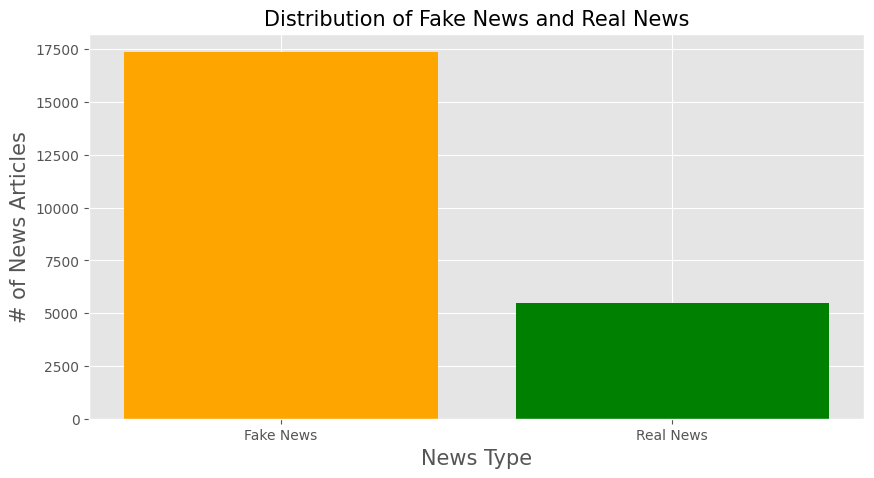

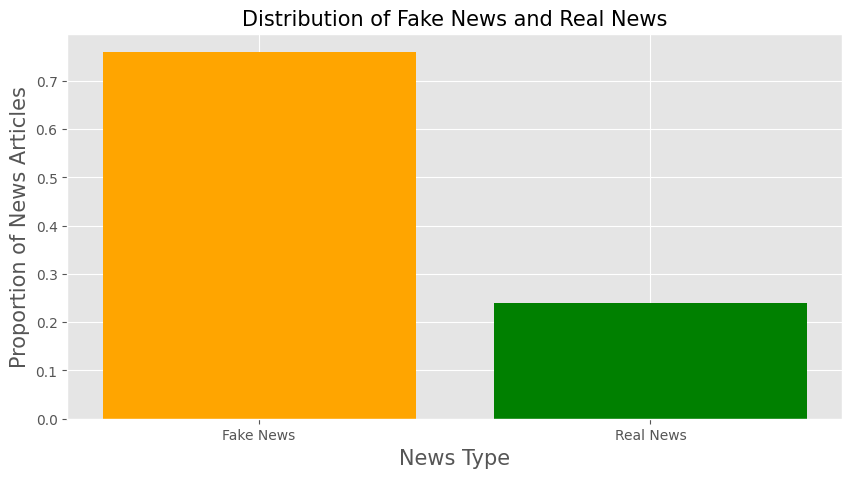

In [ ]:
grouped = news_df.groupby(news_df.label)
real_df = grouped.get_group(0)
fake_df = grouped.get_group(1)

plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)

total_len = len(fake_df) + len(real_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df) / total_len, color='orange')
plt.bar('Real News', len(real_df) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

In [ ]:
print('Number of fake news articles:', len(fake_df))
print('Number of real news articles:', len(real_df))
print('Difference of news articles:', abs(len(real_df) - len(fake_df)))

Number of fake news articles: 17371
Number of real news articles: 5495
Difference of news articles: 11876


## STEP 3: Splitting Training/Testing Data & Tokenization

In [ ]:
features = news_df['title']
targets = news_df['label']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

### Normalizing our data: lower case, get rid of extra spaces, and url links.

In [ ]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

### Convert text to vectors, our classifier only takes numerical data.

In [ ]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

# tokenize the text into vectors
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### Apply padding so we have the same length for each article

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

## STEP 4: Building the Recurrent Neural Network (RNN) Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 256)         263168    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, None, 256)         0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

## STEP 5: Training the Model

### Using early stop to stop training when the validation loss no longer improve

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    batch_size=64,
                    shuffle=True,
                    callbacks=[early_stop])

Epoch 1/20
286/286 [==============================] - 691s 2s/step - loss: 0.4223 - accuracy: 0.8205 - val_loss: 0.3778 - val_accuracy: 0.8476
Epoch 2/20
286/286 [==============================] - 681s 2s/step - loss: 0.2902 - accuracy: 0.8789 - val_loss: 0.3793 - val_accuracy: 0.8459
Epoch 3/20
286/286 [==============================] - 649s 2s/step - loss: 0.2172 - accuracy: 0.9117 - val_loss: 0.4390 - val_accuracy: 0.8229


## STEP 6: Evaluating the Results

### Visualize the training progress over time

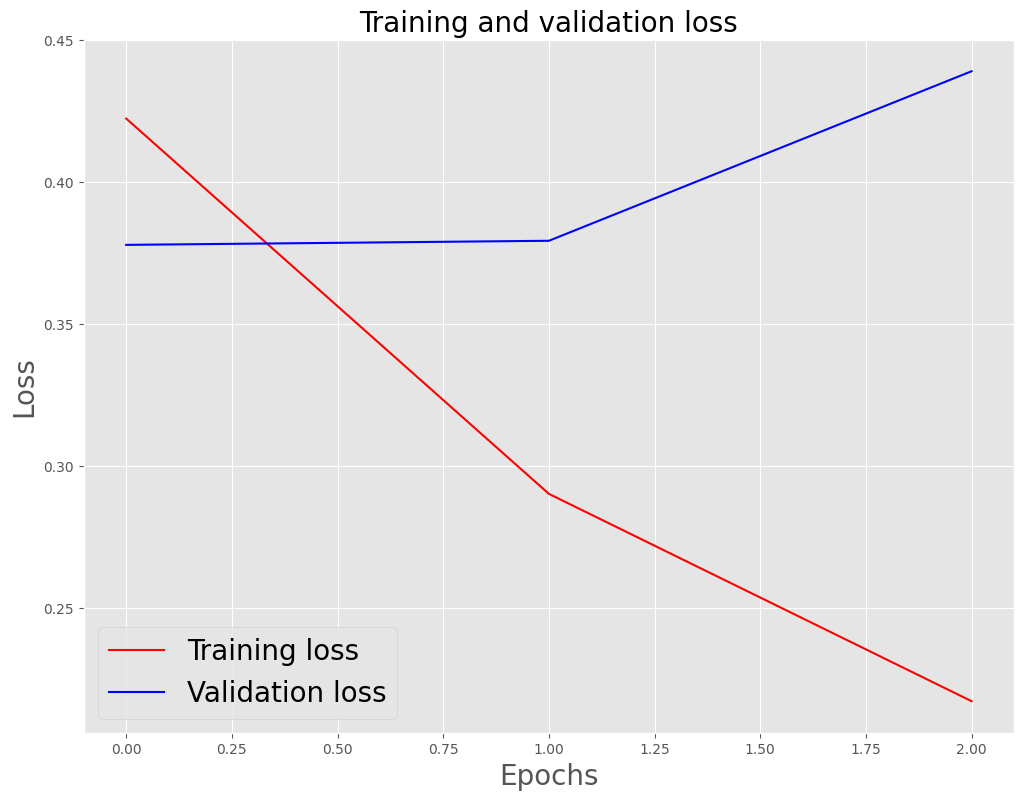

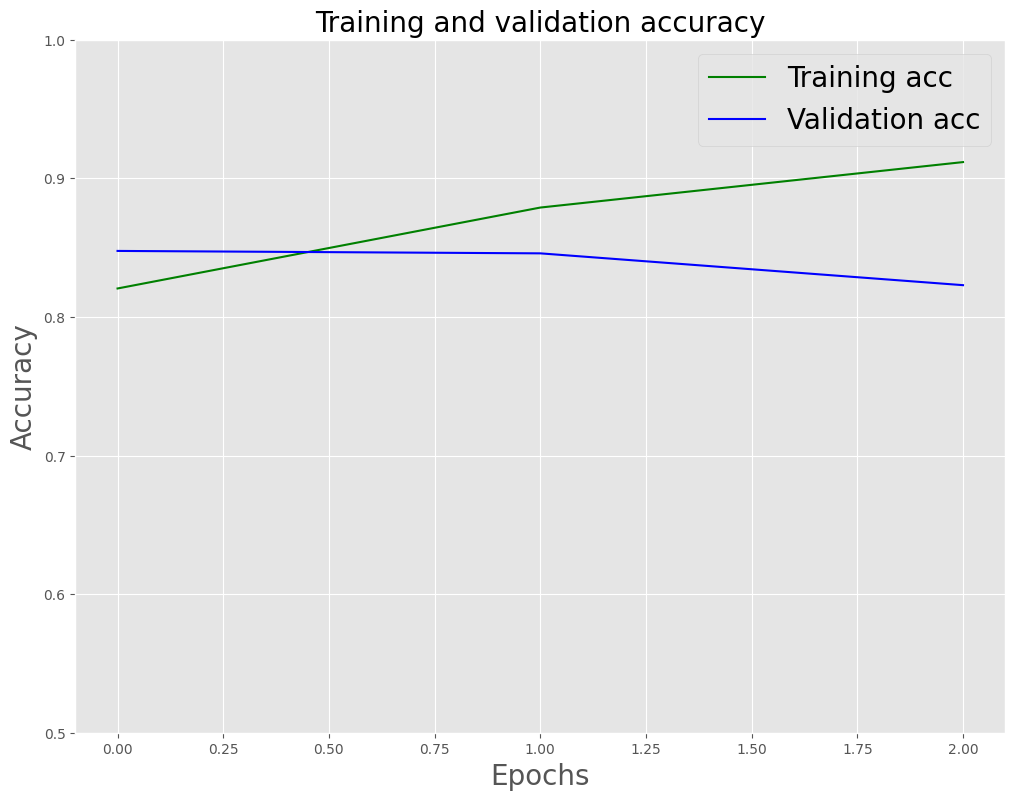

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

### Evaluating the testing set

In [ ]:
model.evaluate(X_test, y_test)

143/143 [==============================] - 63s 441ms/step - loss: 0.3778 - accuracy: 0.8476


[0.37783756852149963, 0.847616970539093]

In [ ]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i <= 0.5:
        binary_predictions.append(0) #predicts the article shows real news
    else:
        binary_predictions.append(1) #predicts the articles shows fake news

143/143 [==============================] - 63s 432ms/step


In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.8476169654569304
Precision on testing set: 0.9379666858127513
Recall on testing set: 0.8716306378436082


### Confusion Matrix

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

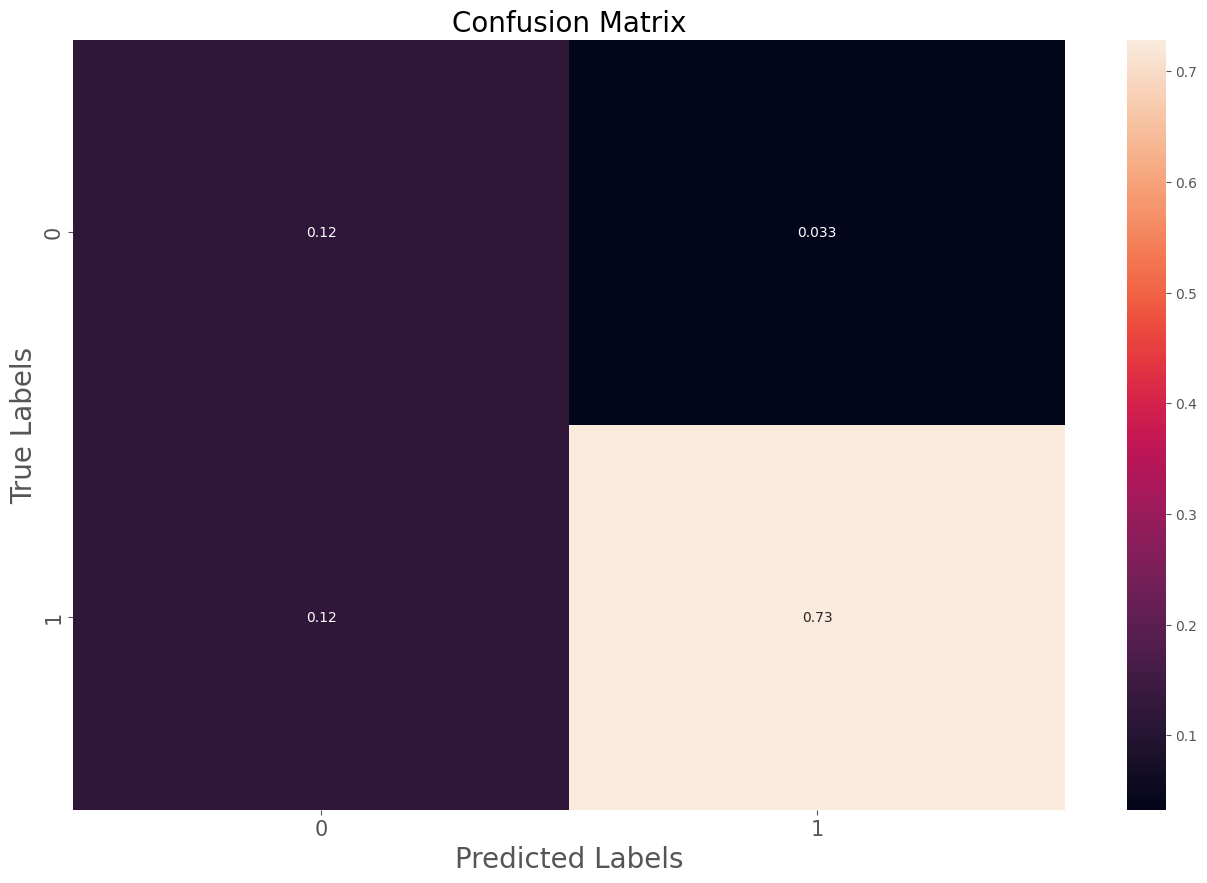

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)